# Tropical Learnable Pooling for Adaptive Feature Aggregation in CNNs

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define a CNN with Fractional Max-Pooling
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Fractional Max-Pooling layers with less aggressive output sizes
        self.pool1 = nn.FractionalMaxPool2d(kernel_size=2, output_ratio=0.9)
        self.pool2 = nn.FractionalMaxPool2d(kernel_size=2, output_ratio=0.9)
        self.pool3 = nn.FractionalMaxPool2d(kernel_size=2, output_ratio=0.9)

        # Calculate the final feature map size
        self.final_feature_size = self._calculate_final_feature_size()

        # Fully connected layers
        self.fc1 = nn.Linear(128 * self.final_feature_size * self.final_feature_size, 256)
        self.fc2 = nn.Linear(256, 10)

    def _calculate_final_feature_size(self):
        # Simulate the forward pass to calculate the final feature map size
        x = torch.randn(1, 3, 32, 32)  # Batch size 1, CIFAR-10 input size
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        return x.size(2)  # Height of the final feature map

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))

        # Flatten the output for fully connected layers
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Define a CNN with Tropical Learnable Fractional Pooling
class TropicalFractionalPool2d(nn.Module):
    def __init__(self, kernel_size=2, output_size=(4, 4)):
        super(TropicalFractionalPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.output_size = output_size

        # Learnable weights for tropical multiplication (addition in tropical algebra)
        self.weights = nn.Parameter(torch.randn(kernel_size, kernel_size) * 0.01)

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        out_height, out_width = self.output_size

        output = torch.zeros(batch_size, channels, out_height, out_width).to(x.device)

        for i in range(out_height):
            for j in range(out_width):
                h_start = int(i * height / out_height)
                w_start = int(j * width / out_width)
                h_end = h_start + self.kernel_size
                w_end = w_start + self.kernel_size
                region = x[:, :, h_start:h_end, w_start:w_end]

                # Tropical multiplication: Add learnable weights (equivalent to multiplication in tropical algebra)
                region_with_weights = region + self.weights  # Element-wise addition

                # Tropical addition: Take the maximum (equivalent to addition in tropical algebra)
                output[:, :, i, j] = region_with_weights.max(dim=2)[0].max(dim=2)[0]

        return output

class TropicalConvNet(nn.Module):
    def __init__(self):
        super(TropicalConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # Adjusted for CIFAR-10
        self.fc2 = nn.Linear(256, 10)

        # Tropical Fractional Pooling layers with adjusted output sizes
        self.pool1 = TropicalFractionalPool2d(kernel_size=2, output_size=(16, 16))
        self.pool2 = TropicalFractionalPool2d(kernel_size=2, output_size=(8, 8))
        self.pool3 = TropicalFractionalPool2d(kernel_size=2, output_size=(4, 4))

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))

        # Flatten the output for fully connected layers
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Initialize models
model_classic = ConvNet().to(device)
model_tropical = TropicalConvNet().to(device)

# Define loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer_classic = optim.Adam(model_classic.parameters(), lr=0.001)
optimizer_tropical = optim.Adam(model_tropical.parameters(), lr=0.001)

# Function to train the model
def train_model(model, trainloader, criterion, optimizer, epochs=20):
    loss_list = []
    accuracy_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        loss_list.append(running_loss / len(trainloader))
        accuracy_list.append(100 * correct / total)

        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, Accuracy: {100 * correct / total}%")

    return loss_list, accuracy_list

# Function to evaluate the model on the test set
def evaluate_model(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(testloader)
    accuracy = 100 * correct / total

    print(f"Test Loss: {test_loss}, Test Accuracy: {accuracy}%")
    return test_loss, accuracy

# Train both models
print("Training Classic Model:")
loss_classic, accuracy_classic = train_model(model_classic, trainloader, criterion, optimizer_classic)

print("Training Tropical Model:")
loss_tropical, accuracy_tropical = train_model(model_tropical, trainloader, criterion, optimizer_tropical)

# Evaluate both models on the test set
print("Evaluating Classic Model:")
test_loss_classic, test_accuracy_classic = evaluate_model(model_classic, testloader, criterion)

print("Evaluating Tropical Model:")
test_loss_tropical, test_accuracy_tropical = evaluate_model(model_tropical, testloader, criterion)

# Plot training loss and accuracy
fig = make_subplots(rows=1, cols=2, subplot_titles=("Training Loss", "Training Accuracy"))

# Add loss plots
fig.add_trace(go.Scatter(x=list(range(1, len(loss_classic) + 1)), y=loss_classic, mode='lines', name='Loss (Classic)'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(loss_tropical) + 1)), y=loss_tropical, mode='lines', name='Loss (Tropical)'), row=1, col=1)

# Add accuracy plots
fig.add_trace(go.Scatter(x=list(range(1, len(accuracy_classic) + 1)), y=accuracy_classic, mode='lines', name='Accuracy (Classic)'), row=1, col=2)
fig.add_trace(go.Scatter(x=list(range(1, len(accuracy_tropical) + 1)), y=accuracy_tropical, mode='lines', name='Accuracy (Tropical)'), row=1, col=2)

# Update layout
fig.update_layout(
    title="Training Loss and Accuracy Comparison (Classic vs Tropical Fractional Pooling)",
    xaxis_title="Epoch",
    yaxis_title="Value",
    legend_title="Metrics",
    template="plotly_dark",
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='gray'),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='gray')
)

fig.show()

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Training Classic Model:
Epoch 1, Loss: 1.284401359765426, Accuracy: 54.292%
Epoch 2, Loss: 0.8748642506501864, Accuracy: 69.258%
Epoch 3, Loss: 0.7022086375814569, Accuracy: 75.32%
Epoch 4, Loss: 0.5639375090751502, Accuracy: 80.134%
Epoch 5, Loss: 0.4434910589433692, Accuracy: 84.368%
Epoch 6, Loss: 0.345131379659371, Accuracy: 87.69%
Epoch 7, Loss: 0.2699559501674779, Accuracy: 90.3%
Epoch 8, Loss: 0.21687368085831785, Accuracy: 92.206%
Epoch 9, Loss: 0.18169046823135424, Accuracy: 93.62%
Epoch 10, Loss: 0.16102150520143074, Accuracy: 94.4%
Epoch 11, Loss: 0.1460873162144047, Accuracy: 94.924%
Epoch 12, Loss: 0.12919226924405264, Accuracy: 95.506%
Epoch 13, Loss: 0.12275837314293703, Accuracy: 95.75%
Epoch 14, Loss: 0.11675843978276872, Accuracy: 96.096%
Epoch 15, Loss: 0.10865224020965301, Accuracy: 96.29%
Epoch 16, Loss: 0.10445977582821332, Accuracy: 96.542%
Epoch 17, Loss: 0.09521841776

KeyboardInterrupt: 

# Итоговое сравнение

Using device: cuda


100%|██████████| 170M/170M [00:03<00:00, 44.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training Max Pooling Model:
Epoch 1, Loss: 1.3781734715642222, Accuracy: 50.044%
Epoch 2, Loss: 0.9337023225281854, Accuracy: 66.914%
Epoch 3, Loss: 0.7485123782435341, Accuracy: 73.714%
Epoch 4, Loss: 0.6247243339295887, Accuracy: 78.236%
Epoch 5, Loss: 0.5182847938574183, Accuracy: 81.848%
Epoch 6, Loss: 0.4271918689389058, Accuracy: 84.92%
Epoch 7, Loss: 0.3383606320337566, Accuracy: 88.014%
Epoch 8, Loss: 0.2655346406733288, Accuracy: 90.638%
Epoch 9, Loss: 0.20373583710311777, Accuracy: 92.788%
Epoch 10, Loss: 0.16127810971644682, Accuracy: 94.266%
Epoch 11, Loss: 0.13039481442879, Accuracy: 95.446%
Epoch 12, Loss: 0.11347416441535096, Accuracy: 96.018%
Epoch 13, Loss: 0.09602318977689385, Accuracy: 96.608%
Epoch 14, Loss: 0.09191346919411779, Accuracy: 96.794%
Epoch 15, Loss: 0.08716006508833059, Accuracy: 96.95%
Epoch 16, Loss: 0.076602808451411, Accuracy: 97.262%
Epoch 17, Loss: 0.069713105

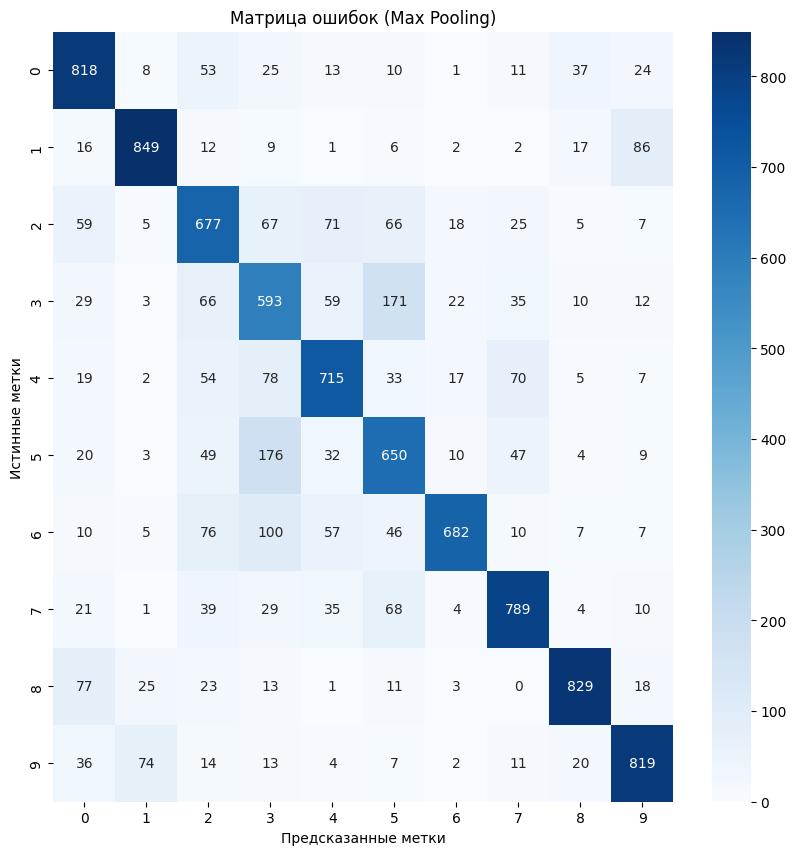

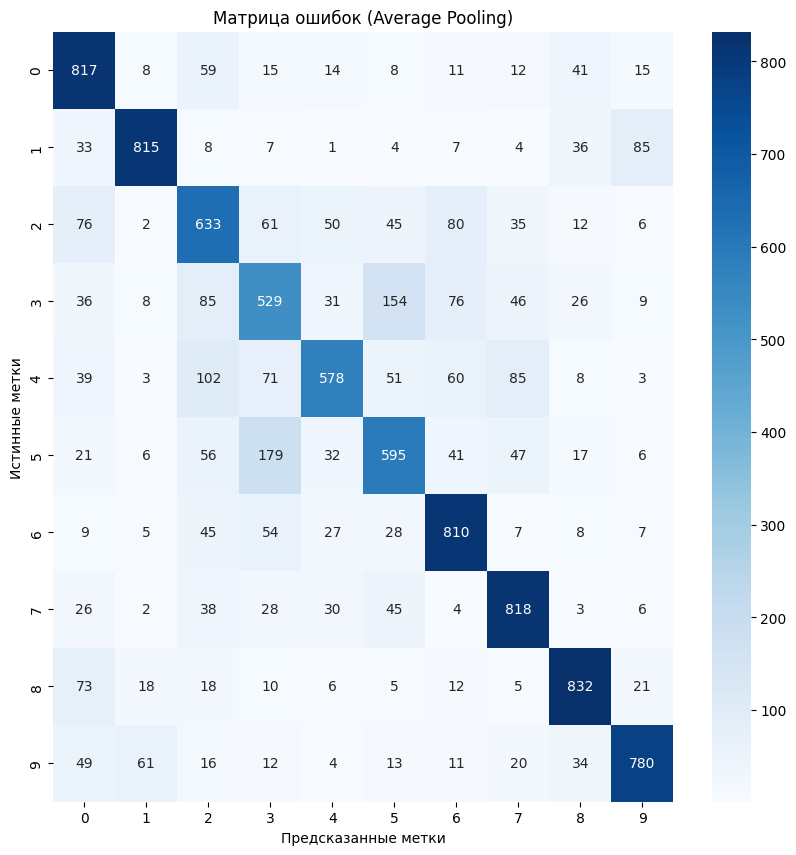

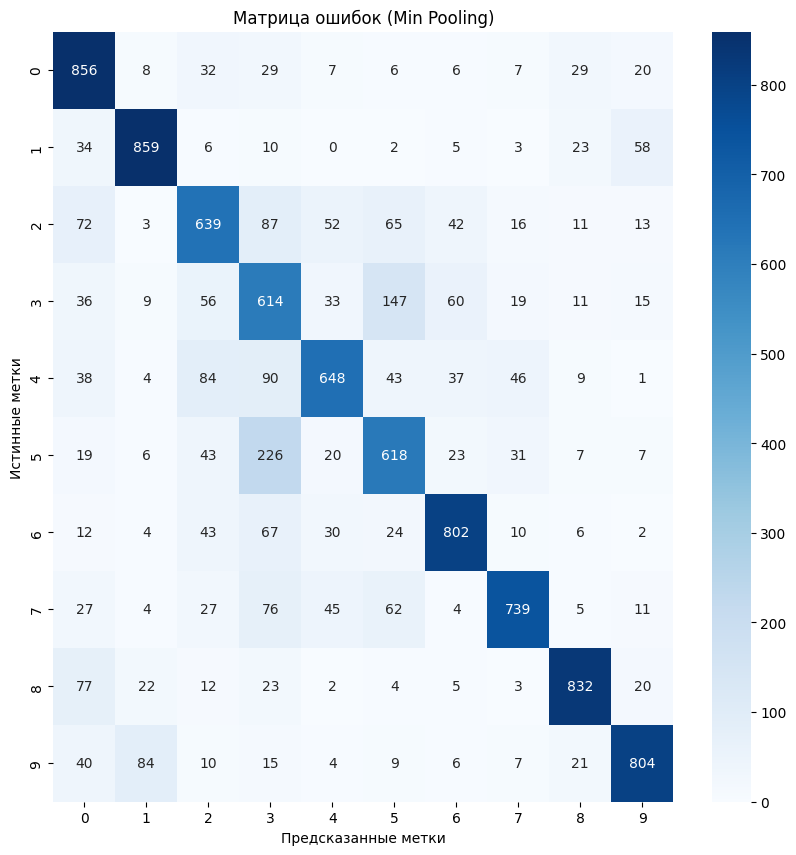

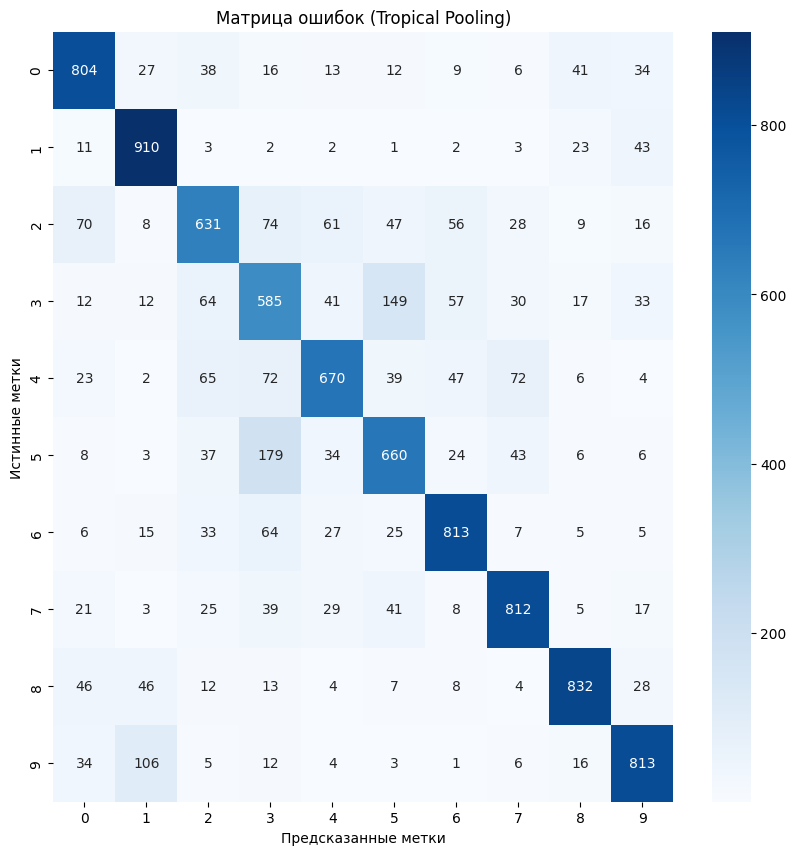

In [ ]:
# Не верно. Использует единый пуллер
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define a CNN with classical max pooling
class ConvNet(nn.Module):
    def __init__(self, pooling_type='max'):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # Adjusted for CIFAR-10
        self.fc2 = nn.Linear(256, 10)

        # Pooling layer
        if pooling_type == 'max':
            self.pool = nn.MaxPool2d(2, 2)  # Kernel size 2x2, stride 2
        elif pooling_type == 'avg':
            self.pool = nn.AvgPool2d(2, 2)  # Kernel size 2x2, stride 2
        elif pooling_type == 'min':
            self.pool = nn.MaxPool2d(2, 2)  # Kernel size 2x2, stride 2

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        # Flatten the output for fully connected layers
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Define a CNN with tropical max pooling
class TropicalMaxPool2d(nn.Module):
    def __init__(self, kernel_size=2, stride=2, padding=0):
        super(TropicalMaxPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Learnable weights for tropical multiplication (addition in tropical algebra)
        self.weights = nn.Parameter(torch.randn(kernel_size, kernel_size) * 0.01)

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        x_padded = nn.functional.pad(x, (self.padding, self.padding, self.padding, self.padding))

        out_height = (height - self.kernel_size + 2 * self.padding) // self.stride + 1
        out_width = (width - self.kernel_size + 2 * self.padding) // self.stride + 1

        output = torch.zeros(batch_size, channels, out_height, out_width).to(x.device)

        for i in range(out_height):
            for j in range(out_width):
                h_start = i * self.stride
                w_start = j * self.stride
                h_end = h_start + self.kernel_size
                w_end = w_start + self.kernel_size
                region = x_padded[:, :, h_start:h_end, w_start:w_end]

                # Tropical multiplication: Add learnable weights (equivalent to multiplication in tropical algebra)
                region_with_weights = region + self.weights  # Element-wise addition

                # Tropical addition: Take the maximum (equivalent to addition in tropical algebra)
                output[:, :, i, j] = region_with_weights.max(dim=2)[0].max(dim=2)[0]

        return output

class TropicalConvNet(nn.Module):
    def __init__(self):
        super(TropicalConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # Adjusted for CIFAR-10
        self.fc2 = nn.Linear(256, 10)

        # Tropical max pooling layer
        self.pool = TropicalMaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        # Flatten the output for fully connected layers
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Initialize models
model_max = ConvNet(pooling_type='max').to(device)
model_avg = ConvNet(pooling_type='avg').to(device)
model_min = ConvNet(pooling_type='min').to(device)
model_tropical = TropicalConvNet().to(device)

# Define loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer_max = optim.Adam(model_max.parameters(), lr=0.001)
optimizer_avg = optim.Adam(model_avg.parameters(), lr=0.001)
optimizer_min = optim.Adam(model_min.parameters(), lr=0.001)
optimizer_tropical = optim.Adam(model_tropical.parameters(), lr=0.001)

# Function to train the model
def train_model(model, trainloader, criterion, optimizer, epochs=20):
    loss_list = []
    accuracy_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        loss_list.append(running_loss / len(trainloader))
        accuracy_list.append(100 * correct / total)

        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, Accuracy: {100 * correct / total}%")

    return loss_list, accuracy_list

# Function to evaluate the model on the test set
def evaluate_model(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(testloader)
    accuracy = 100 * correct / total

    print(f"Test Loss: {test_loss}, Test Accuracy: {accuracy}%")
    return test_loss, accuracy

# Train all models
print("Training Max Pooling Model:")
loss_max, accuracy_max = train_model(model_max, trainloader, criterion, optimizer_max)

print("Training Average Pooling Model:")
loss_avg, accuracy_avg = train_model(model_avg, trainloader, criterion, optimizer_avg)

print("Training Min Pooling Model:")
loss_min, accuracy_min = train_model(model_min, trainloader, criterion, optimizer_min)

print("Training Tropical Model:")
loss_tropical, accuracy_tropical = train_model(model_tropical, trainloader, criterion, optimizer_tropical)

# Evaluate all models on the test set
print("Evaluating Max Pooling Model:")
test_loss_max, test_accuracy_max = evaluate_model(model_max, testloader, criterion)

print("Evaluating Average Pooling Model:")
test_loss_avg, test_accuracy_avg = evaluate_model(model_avg, testloader, criterion)

print("Evaluating Min Pooling Model:")
test_loss_min, test_accuracy_min = evaluate_model(model_min, testloader, criterion)

print("Evaluating Tropical Model:")
test_loss_tropical, test_accuracy_tropical = evaluate_model(model_tropical, testloader, criterion)

# Plot training loss and accuracy
fig = make_subplots(rows=1, cols=2, subplot_titles=("Потери при обучении", "Точность при обучении"))

# Add loss plots
fig.add_trace(go.Scatter(x=list(range(1, len(loss_max) + 1)), y=loss_max, mode='lines', name='Max Pooling'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(loss_avg) + 1)), y=loss_avg, mode='lines', name='Average Pooling'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(loss_min) + 1)), y=loss_min, mode='lines', name='Min Pooling'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(loss_tropical) + 1)), y=loss_tropical, mode='lines', name='Tropical Pooling'), row=1, col=1)

# Add accuracy plots
fig.add_trace(go.Scatter(x=list(range(1, len(accuracy_max) + 1)), y=accuracy_max, mode='lines', name='Max Pooling'), row=1, col=2)
fig.add_trace(go.Scatter(x=list(range(1, len(accuracy_avg) + 1)), y=accuracy_avg, mode='lines', name='Average Pooling'), row=1, col=2)
fig.add_trace(go.Scatter(x=list(range(1, len(accuracy_min) + 1)), y=accuracy_min, mode='lines', name='Min Pooling'), row=1, col=2)
fig.add_trace(go.Scatter(x=list(range(1, len(accuracy_tropical) + 1)), y=accuracy_tropical, mode='lines', name='Tropical Pooling'), row=1, col=2)

# Update layout
fig.update_layout(
    title="Сравнение потерь и точности при обучении",
    xaxis_title="Эпоха",
    yaxis_title="Значение",
    legend_title="Метрики",
    template="plotly_dark",
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='gray'),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='gray')
)

fig.show()

# Function to plot confusion matrix
def plot_confusion_matrix(model, testloader, title):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Предсказанные метки')
    plt.ylabel('Истинные метки')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(model_max, testloader, "Матрица ошибок (Max Pooling)")
plot_confusion_matrix(model_avg, testloader, "Матрица ошибок (Average Pooling)")
plot_confusion_matrix(model_min, testloader, "Матрица ошибок (Min Pooling)")
plot_confusion_matrix(model_tropical, testloader, "Матрица ошибок (Tropical Pooling)")

Using device: cuda


100%|██████████| 170M/170M [00:05<00:00, 29.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training Max Pooling Model:
Epoch 1, Loss: 1.3817785495077557, Accuracy: 50.07%
Epoch 2, Loss: 0.9588575910424333, Accuracy: 66.448%
Epoch 3, Loss: 0.7657798053053639, Accuracy: 73.02%
Epoch 4, Loss: 0.6366824093072311, Accuracy: 77.768%
Epoch 5, Loss: 0.5294493180521004, Accuracy: 81.478%
Epoch 6, Loss: 0.4376977755095038, Accuracy: 84.662%
Epoch 7, Loss: 0.3485524898199627, Accuracy: 87.534%
Epoch 8, Loss: 0.27527930497017966, Accuracy: 90.21%
Epoch 9, Loss: 0.21189623871994445, Accuracy: 92.556%
Epoch 10, Loss: 0.16174734102519195, Accuracy: 94.338%
Epoch 11, Loss: 0.138198311905117, Accuracy: 95.004%
Epoch 12, Loss: 0.11387095521049351, Accuracy: 95.95%
Epoch 13, Loss: 0.09578465242260385, Accuracy: 96.576%
Epoch 14, Loss: 0.08923454287425017, Accuracy: 96.82%
Epoch 15, Loss: 0.08940510948836479, Accuracy: 96.89%
Epoch 16, Loss: 0.08648083775775874, Accuracy: 96.926%
Epoch 17, Loss: 0.065286648

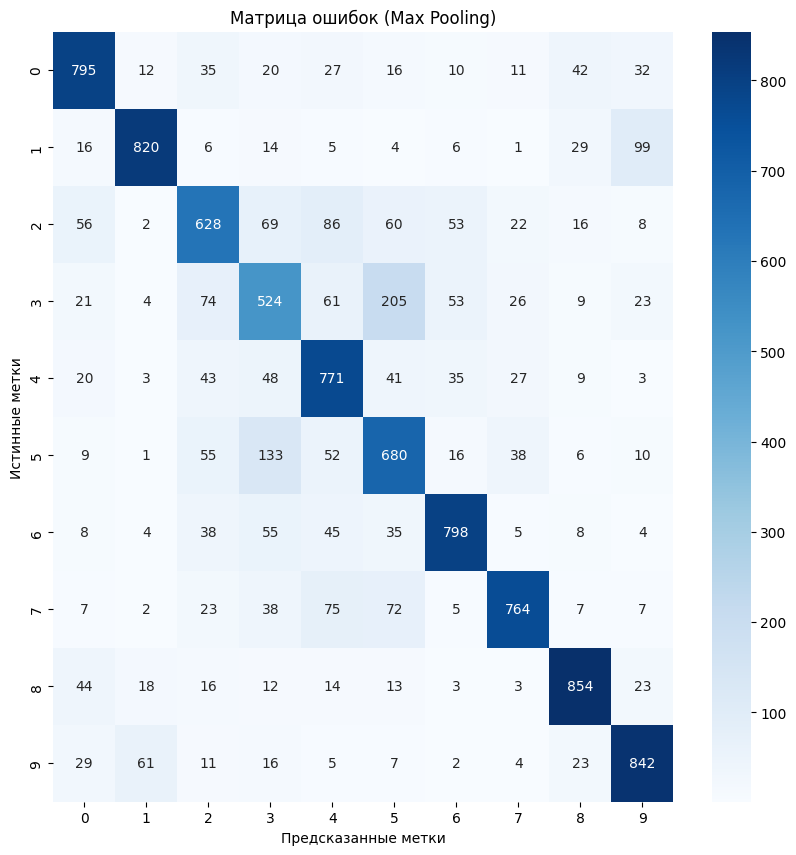

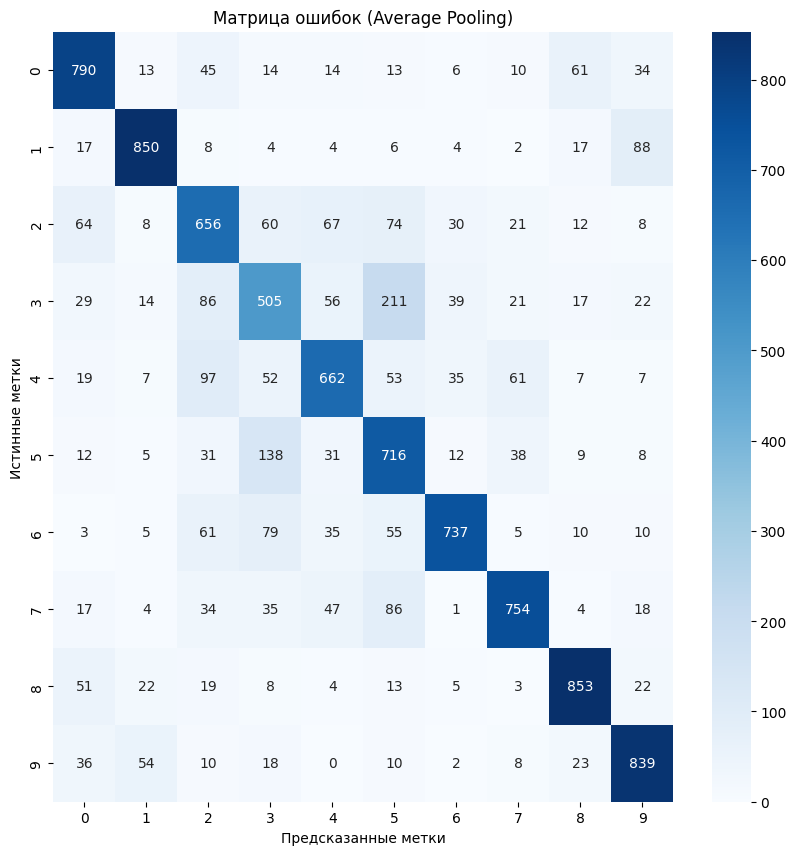

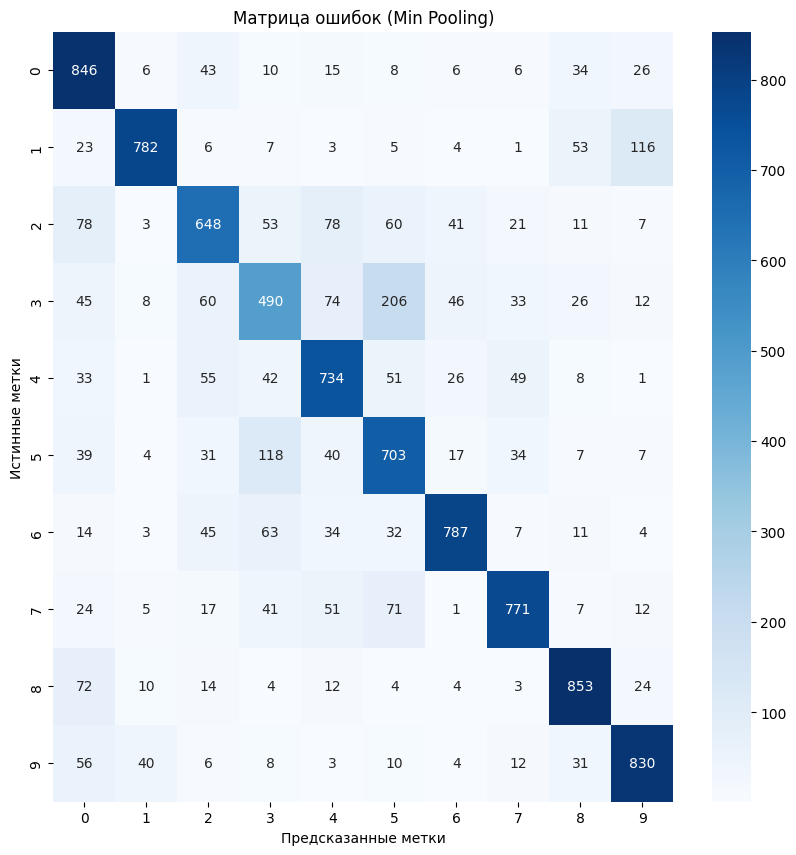

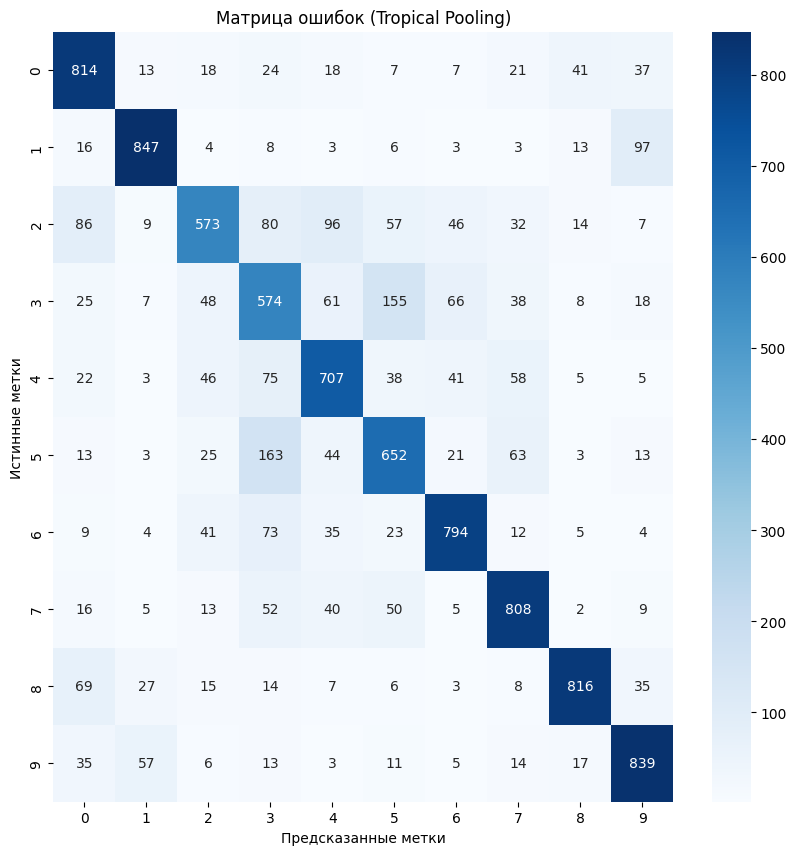

In [ ]:
# Пересчет для светлой темы
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define a CNN with classical max pooling
class ConvNet(nn.Module):
    def __init__(self, pooling_type='max'):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # Adjusted for CIFAR-10
        self.fc2 = nn.Linear(256, 10)

        # Pooling layer
        if pooling_type == 'max':
            self.pool = nn.MaxPool2d(2, 2)  # Kernel size 2x2, stride 2
        elif pooling_type == 'avg':
            self.pool = nn.AvgPool2d(2, 2)  # Kernel size 2x2, stride 2
        elif pooling_type == 'min':
            self.pool = nn.MaxPool2d(2, 2)  # Kernel size 2x2, stride 2

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        # Flatten the output for fully connected layers
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Define a CNN with tropical max pooling
class TropicalMaxPool2d(nn.Module):
    def __init__(self, kernel_size=2, stride=2, padding=0):
        super(TropicalMaxPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Learnable weights for tropical multiplication (addition in tropical algebra)
        self.weights = nn.Parameter(torch.randn(kernel_size, kernel_size) * 0.01)

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        x_padded = nn.functional.pad(x, (self.padding, self.padding, self.padding, self.padding))

        out_height = (height - self.kernel_size + 2 * self.padding) // self.stride + 1
        out_width = (width - self.kernel_size + 2 * self.padding) // self.stride + 1

        output = torch.zeros(batch_size, channels, out_height, out_width).to(x.device)

        for i in range(out_height):
            for j in range(out_width):
                h_start = i * self.stride
                w_start = j * self.stride
                h_end = h_start + self.kernel_size
                w_end = w_start + self.kernel_size
                region = x_padded[:, :, h_start:h_end, w_start:w_end]

                # Tropical multiplication: Add learnable weights (equivalent to multiplication in tropical algebra)
                region_with_weights = region + self.weights  # Element-wise addition

                # Tropical addition: Take the maximum (equivalent to addition in tropical algebra)
                output[:, :, i, j] = region_with_weights.max(dim=2)[0].max(dim=2)[0]

        return output

class TropicalConvNet(nn.Module):
    def __init__(self):
        super(TropicalConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # Adjusted for CIFAR-10
        self.fc2 = nn.Linear(256, 10)

        # Tropical max pooling layer
        self.pool = TropicalMaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        # Flatten the output for fully connected layers
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Initialize models
model_max = ConvNet(pooling_type='max').to(device)
model_avg = ConvNet(pooling_type='avg').to(device)
model_min = ConvNet(pooling_type='min').to(device)
model_tropical = TropicalConvNet().to(device)

# Define loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer_max = optim.Adam(model_max.parameters(), lr=0.001)
optimizer_avg = optim.Adam(model_avg.parameters(), lr=0.001)
optimizer_min = optim.Adam(model_min.parameters(), lr=0.001)
optimizer_tropical = optim.Adam(model_tropical.parameters(), lr=0.001)

# Function to train the model
def train_model(model, trainloader, criterion, optimizer, epochs=20):
    loss_list = []
    accuracy_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        loss_list.append(running_loss / len(trainloader))
        accuracy_list.append(100 * correct / total)

        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, Accuracy: {100 * correct / total}%")

    return loss_list, accuracy_list

# Function to evaluate the model on the test set
def evaluate_model(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(testloader)
    accuracy = 100 * correct / total

    print(f"Test Loss: {test_loss}, Test Accuracy: {accuracy}%")
    return test_loss, accuracy

# Train all models
print("Training Max Pooling Model:")
loss_max, accuracy_max = train_model(model_max, trainloader, criterion, optimizer_max)

print("Training Average Pooling Model:")
loss_avg, accuracy_avg = train_model(model_avg, trainloader, criterion, optimizer_avg)

print("Training Min Pooling Model:")
loss_min, accuracy_min = train_model(model_min, trainloader, criterion, optimizer_min)

print("Training Tropical Model:")
loss_tropical, accuracy_tropical = train_model(model_tropical, trainloader, criterion, optimizer_tropical)

# Evaluate all models on the test set
print("Evaluating Max Pooling Model:")
test_loss_max, test_accuracy_max = evaluate_model(model_max, testloader, criterion)

print("Evaluating Average Pooling Model:")
test_loss_avg, test_accuracy_avg = evaluate_model(model_avg, testloader, criterion)

print("Evaluating Min Pooling Model:")
test_loss_min, test_accuracy_min = evaluate_model(model_min, testloader, criterion)

print("Evaluating Tropical Model:")
test_loss_tropical, test_accuracy_tropical = evaluate_model(model_tropical, testloader, criterion)

# Plot training loss and accuracy
fig = make_subplots(rows=1, cols=2, subplot_titles=("Потери при обучении", "Точность при обучении"))

# Add loss plots
fig.add_trace(go.Scatter(x=list(range(1, len(loss_max) + 1)), y=loss_max, mode='lines', name='Max Pooling'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(loss_avg) + 1)), y=loss_avg, mode='lines', name='Average Pooling'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(loss_min) + 1)), y=loss_min, mode='lines', name='Min Pooling'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(loss_tropical) + 1)), y=loss_tropical, mode='lines', name='Tropical Pooling'), row=1, col=1)

# Add accuracy plots
fig.add_trace(go.Scatter(x=list(range(1, len(accuracy_max) + 1)), y=accuracy_max, mode='lines', name='Max Pooling'), row=1, col=2)
fig.add_trace(go.Scatter(x=list(range(1, len(accuracy_avg) + 1)), y=accuracy_avg, mode='lines', name='Average Pooling'), row=1, col=2)
fig.add_trace(go.Scatter(x=list(range(1, len(accuracy_min) + 1)), y=accuracy_min, mode='lines', name='Min Pooling'), row=1, col=2)
fig.add_trace(go.Scatter(x=list(range(1, len(accuracy_tropical) + 1)), y=accuracy_tropical, mode='lines', name='Tropical Pooling'), row=1, col=2)

# Update layout
fig.update_layout(
    title="Сравнение потерь и точности при обучении",
    xaxis_title="Эпоха",
    yaxis_title="Значение",
    legend_title="Метрики",
    template="plotly_white",
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='gray'),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='gray')
)

fig.show()

# Function to plot confusion matrix
def plot_confusion_matrix(model, testloader, title):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Предсказанные метки')
    plt.ylabel('Истинные метки')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(model_max, testloader, "Матрица ошибок (Max Pooling)")
plot_confusion_matrix(model_avg, testloader, "Матрица ошибок (Average Pooling)")
plot_confusion_matrix(model_min, testloader, "Матрица ошибок (Min Pooling)")
plot_confusion_matrix(model_tropical, testloader, "Матрица ошибок (Tropical Pooling)")

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Training Max Pooling Model:
Epoch 1, Loss: 1.3687766974844287, Accuracy: 50.222%
Epoch 2, Loss: 0.9292241421425739, Accuracy: 67.224%
Epoch 3, Loss: 0.7472416886969295, Accuracy: 73.732%
Epoch 4, Loss: 0.6219346018703392, Accuracy: 78.252%
Epoch 5, Loss: 0.5198171063685966, Accuracy: 81.73%
Epoch 6, Loss: 0.4277383473027698, Accuracy: 85.058%
Epoch 7, Loss: 0.34110794923342097, Accuracy: 88.014%
Epoch 8, Loss: 0.2745844116220084, Accuracy: 90.306%
Epoch 9, Loss: 0.21678070394832002, Accuracy: 92.328%
Epoch 10, Loss: 0.1699282898022162, Accuracy: 94.092%
Epoch 11, Loss: 0.13284779737329544, Accuracy: 95.334%
Epoch 12, Loss: 0.12167632119858737, Accuracy: 95.714%
Epoch 13, Loss: 0.10351007236072512, Accuracy: 96.334%
Epoch 14, Loss: 0.09872644571789904, Accuracy: 96.524%
Epoch 15, Loss: 0.08660868270432248, Accuracy: 96.904%
Epoch 16, Loss: 0.07877599132453303, Accuracy: 97.222%
Epoch 17, Loss:

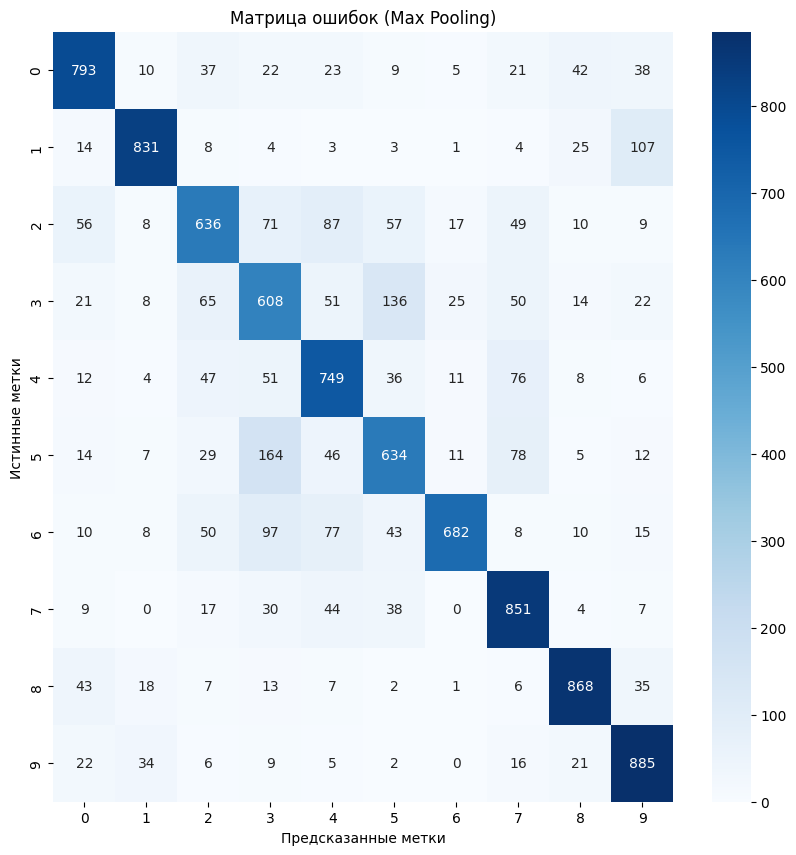

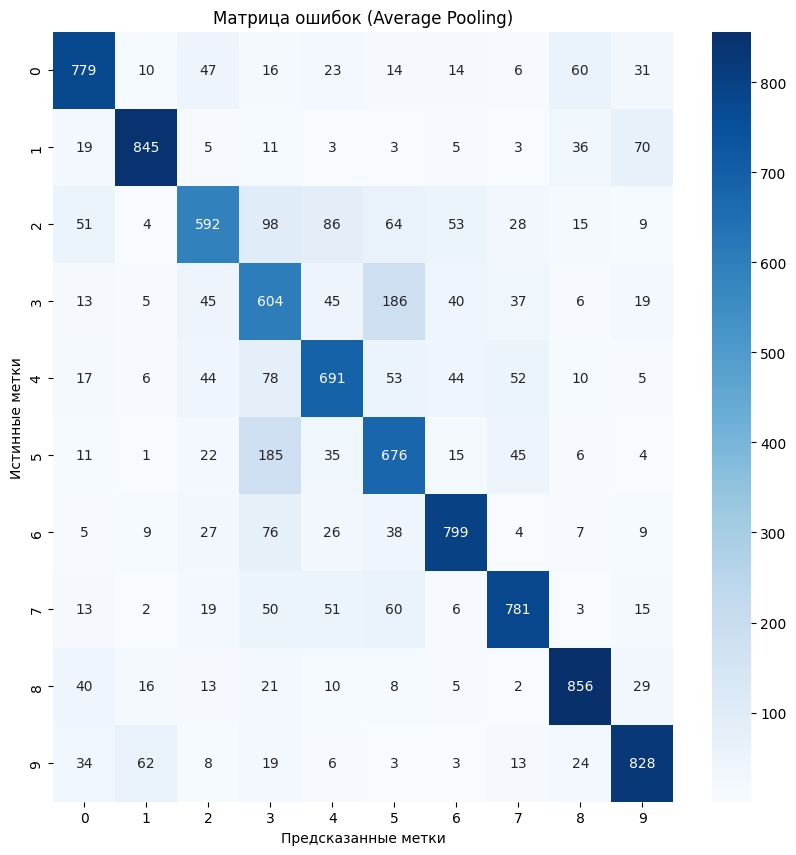

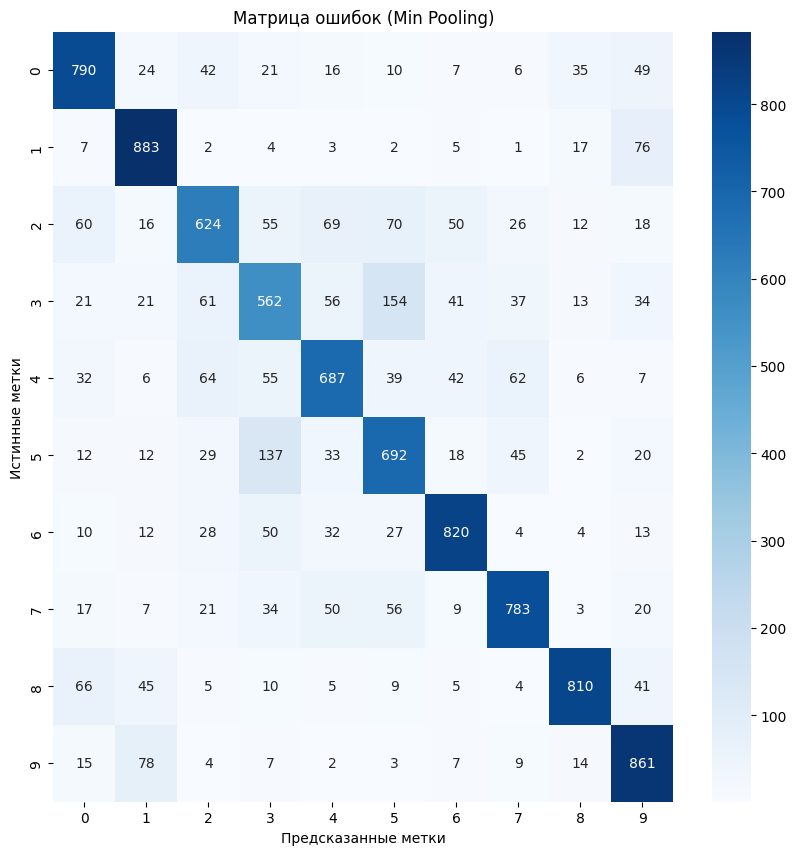

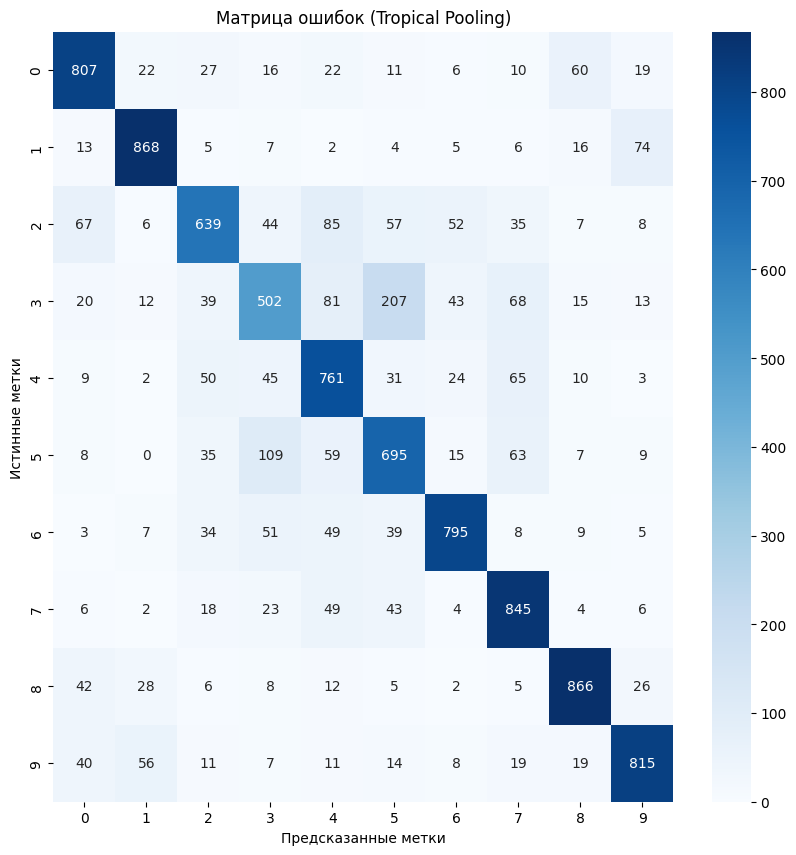

In [ ]:
# Пересчет для светлой темы
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define a CNN with classical max pooling
class ConvNet(nn.Module):
    def __init__(self, pooling_type='max'):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # Adjusted for CIFAR-10
        self.fc2 = nn.Linear(256, 10)

        # Pooling layer
        if pooling_type == 'max':
            self.pool = nn.MaxPool2d(2, 2)  # Kernel size 2x2, stride 2
        elif pooling_type == 'avg':
            self.pool = nn.AvgPool2d(2, 2)  # Kernel size 2x2, stride 2
        elif pooling_type == 'min':
            self.pool = nn.MaxPool2d(2, 2)  # Kernel size 2x2, stride 2

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        # Flatten the output for fully connected layers
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Define a CNN with tropical max pooling
class TropicalMaxPool2d(nn.Module):
    def __init__(self, kernel_size=2, stride=2, padding=0):
        super(TropicalMaxPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Learnable weights for tropical multiplication (addition in tropical algebra)
        self.weights = nn.Parameter(torch.randn(kernel_size, kernel_size) * 0.01)

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        x_padded = nn.functional.pad(x, (self.padding, self.padding, self.padding, self.padding))

        out_height = (height - self.kernel_size + 2 * self.padding) // self.stride + 1
        out_width = (width - self.kernel_size + 2 * self.padding) // self.stride + 1

        output = torch.zeros(batch_size, channels, out_height, out_width).to(x.device)

        for i in range(out_height):
            for j in range(out_width):
                h_start = i * self.stride
                w_start = j * self.stride
                h_end = h_start + self.kernel_size
                w_end = w_start + self.kernel_size
                region = x_padded[:, :, h_start:h_end, w_start:w_end]

                # Tropical multiplication: Add learnable weights (equivalent to multiplication in tropical algebra)
                region_with_weights = region + self.weights  # Element-wise addition

                # Tropical addition: Take the maximum (equivalent to addition in tropical algebra)
                output[:, :, i, j] = region_with_weights.max(dim=2)[0].max(dim=2)[0]

        return output

class TropicalConvNet(nn.Module):
    def __init__(self):
        super(TropicalConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # Adjusted for CIFAR-10
        self.fc2 = nn.Linear(256, 10)

        # Tropical max pooling layer
        self.pool = TropicalMaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        # Flatten the output for fully connected layers
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

def visualize_tropical_weights(model):
    weights = model.pool.weights.detach().cpu().numpy()
    fig, ax = plt.subplots(figsize=(6, 6))
    cax = ax.matshow(weights, cmap='viridis')
    fig.colorbar(cax)
    ax.set_title('Tropical Pooling Weights')
    plt.show()

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Initialize models
model_max = ConvNet(pooling_type='max').to(device)
model_avg = ConvNet(pooling_type='avg').to(device)
model_min = ConvNet(pooling_type='min').to(device)
model_tropical = TropicalConvNet().to(device)

# Define loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer_max = optim.Adam(model_max.parameters(), lr=0.001)
optimizer_avg = optim.Adam(model_avg.parameters(), lr=0.001)
optimizer_min = optim.Adam(model_min.parameters(), lr=0.001)
optimizer_tropical = optim.Adam(model_tropical.parameters(), lr=0.001)

# Function to train the model
def train_model(model, trainloader, criterion, optimizer, epochs=20):
    loss_list = []
    accuracy_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        loss_list.append(running_loss / len(trainloader))
        accuracy_list.append(100 * correct / total)

        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, Accuracy: {100 * correct / total}%")
        visualize_tropical_weights(model)

    return loss_list, accuracy_list

# Function to evaluate the model on the test set
def evaluate_model(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(testloader)
    accuracy = 100 * correct / total

    print(f"Test Loss: {test_loss}, Test Accuracy: {accuracy}%")
    return test_loss, accuracy

# Train all models
print("Training Max Pooling Model:")
loss_max, accuracy_max = train_model(model_max, trainloader, criterion, optimizer_max)

print("Training Average Pooling Model:")
loss_avg, accuracy_avg = train_model(model_avg, trainloader, criterion, optimizer_avg)

print("Training Min Pooling Model:")
loss_min, accuracy_min = train_model(model_min, trainloader, criterion, optimizer_min)

print("Training Tropical Model:")
loss_tropical, accuracy_tropical = train_model(model_tropical, trainloader, criterion, optimizer_tropical)

# Evaluate all models on the test set
print("Evaluating Max Pooling Model:")
test_loss_max, test_accuracy_max = evaluate_model(model_max, testloader, criterion)

print("Evaluating Average Pooling Model:")
test_loss_avg, test_accuracy_avg = evaluate_model(model_avg, testloader, criterion)

print("Evaluating Min Pooling Model:")
test_loss_min, test_accuracy_min = evaluate_model(model_min, testloader, criterion)

print("Evaluating Tropical Model:")
test_loss_tropical, test_accuracy_tropical = evaluate_model(model_tropical, testloader, criterion)

# Plot training loss and accuracy
fig = make_subplots(rows=1, cols=2, subplot_titles=("Training Loss", "Training Accuracy"))

# Add loss plots
fig.add_trace(go.Scatter(x=list(range(1, len(loss_max) + 1)), y=loss_max, mode='lines', name='Max Pooling'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(loss_avg) + 1)), y=loss_avg, mode='lines', name='Average Pooling'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(loss_min) + 1)), y=loss_min, mode='lines', name='Min Pooling'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(loss_tropical) + 1)), y=loss_tropical, mode='lines', name='Tropical Pooling'), row=1, col=1)

# Add accuracy plots
fig.add_trace(go.Scatter(x=list(range(1, len(accuracy_max) + 1)), y=accuracy_max, mode='lines', name='Max Pooling'), row=1, col=2)
fig.add_trace(go.Scatter(x=list(range(1, len(accuracy_avg) + 1)), y=accuracy_avg, mode='lines', name='Average Pooling'), row=1, col=2)
fig.add_trace(go.Scatter(x=list(range(1, len(accuracy_min) + 1)), y=accuracy_min, mode='lines', name='Min Pooling'), row=1, col=2)
fig.add_trace(go.Scatter(x=list(range(1, len(accuracy_tropical) + 1)), y=accuracy_tropical, mode='lines', name='Tropical Pooling'), row=1, col=2)

# Update layout
fig.update_layout(
    title="Training Loss and Accuracy Comparison",
    xaxis_title="Epoch",
    yaxis_title="Value",
    legend_title="Metrics",
    template="plotly_white",
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='gray'),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='gray')
)

fig.show()

# Function to plot confusion matrix
def plot_confusion_matrix(model, testloader, title):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(model_max, testloader, "Confusion_matrix (Max Pooling)")
plot_confusion_matrix(model_avg, testloader, "Confusion_matrix (Average Pooling)")
plot_confusion_matrix(model_min, testloader, "Confusion_matrix (Min Pooling)")
plot_confusion_matrix(model_tropical, testloader, "Confusion_matrix (Tropical Pooling)")